In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import random
import time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [0]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [5]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [0]:
valid_data = copy.deepcopy(valid_data)

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [0]:
class RotationCollator:
    def __init__(self, rotations, train_transform, test_transform):
        self.rotations = rotations
        self.train_transform = train_transform
        self.test_transform = test_transform

    def train_collate(self, batch):
        return self.collate(batch, self.train_transform)

    def test_collate(self, batch):
        return self.collate(batch, self.test_transform)

    def collate(self, batch, transform):    
        images, labels = zip(*batch)
        
        _images = []
        _labels = []
        
        for image in images:
            rotation = random.randrange(0, len(self.rotations))
            image = transforms.functional.rotate(image, self.rotations[rotation])
            label = rotation
            image = transform(image)
            _images.append(image)
            _labels.append(label)

        _images = torch.stack(_images)
        _labels = torch.LongTensor(_labels)

        return _images, _labels

In [0]:
rotations = [0, 90, 180, 270]

collator = RotationCollator(rotations, train_transforms, test_transforms)

In [0]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE,
                                 collate_fn = collator.train_collate)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE,
                                 collate_fn = collator.test_collate)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE,
                                collate_fn = collator.test_collate)

In [0]:
iterator = copy.deepcopy(train_iterator)

In [0]:
images, labels = next(iter(iterator))

In [0]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [0]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize= (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(f'Rotation = {label}')
        ax.axis('off')

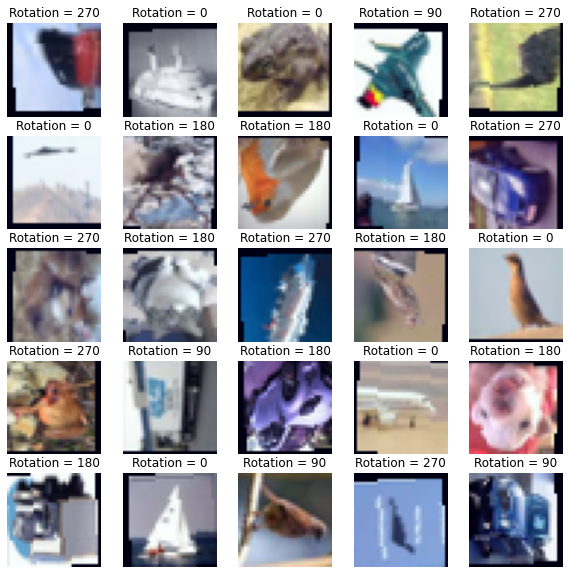

In [16]:
N_IMAGES = 25

images = images[:N_IMAGES]
labels = labels[:N_IMAGES]

plot_images(images, labels, rotations)

In [0]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, in_channels, out_channels = config
            
        assert len(layers) == len(in_channels) == len(out_channels) == 4
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = get_resnet_layer(block, layers[0], in_channels[0], 
                                       out_channels[0])
        
        self.layer2 = get_resnet_layer(block, layers[1], in_channels[1], 
                                       out_channels[1], stride = 2)
        
        self.layer3 = get_resnet_layer(block, layers[2], in_channels[2], 
                                       out_channels[2], stride = 2)
        
        self.layer4 = get_resnet_layer(block, layers[3], in_channels[3], 
                                       out_channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, output_dim)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x

In [0]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, 
                                       bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [0]:
def get_resnet_layer(block, n_blocks, in_channels, out_channels, stride = 1):
    
    layers = []
    
    if in_channels != out_channels:
        downsample = True
    else:
        downsample = False
                
    layers.append(block(in_channels, out_channels, stride, downsample))
    
    for i in range(1, n_blocks):
        layers.append(block(out_channels, out_channels))
    
    return nn.Sequential(*layers)

In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'layers', 'in_channels', 'out_channels'])

In [0]:
resnet18_config = ResNetConfig(block = ResNetBlock,
                               layers = [2,2,2,2],
                               in_channels = [64, 64, 128, 256],
                               out_channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = ResNetBlock,
                               layers = [3,4,6,3],
                               in_channels = [64, 64, 128, 256],
                               out_channels = [64, 128, 256, 512])

In [0]:
PRETRAINING_OUTPUT_DIM = 4

model = ResNet(resnet18_config, PRETRAINING_OUTPUT_DIM)

In [0]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [0]:
model.apply(initialize_parameters);

In [0]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [26]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [0]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

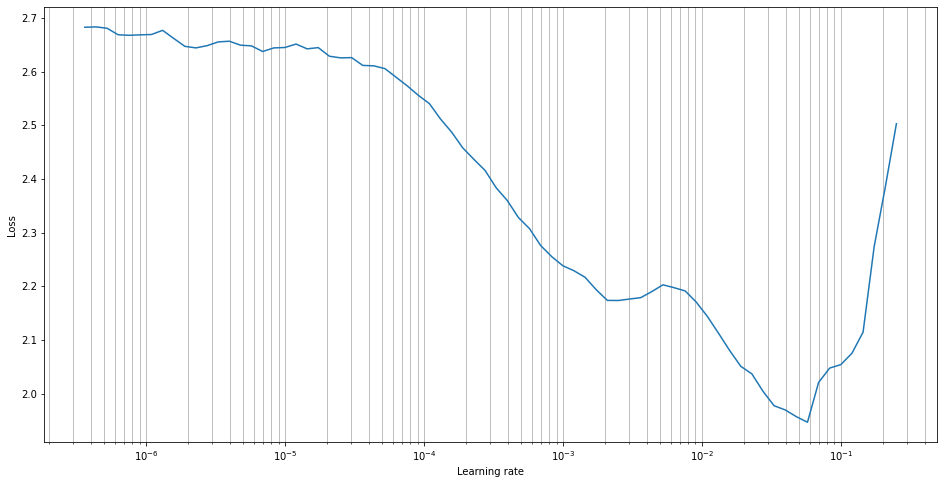

In [28]:
plot_lr_finder(lrs, losses, skip_end = 20)

In [0]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [0]:
EPOCHS = 25
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                    max_lr = FOUND_LR,
                                    total_steps = TOTAL_STEPS)

In [0]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [0]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-pretrained-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.706 | Train Acc: 32.94%
	 Val. Loss: 1.414 |  Val. Acc: 37.08%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 1.390 | Train Acc: 37.95%
	 Val. Loss: 1.290 |  Val. Acc: 40.90%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 1.252 | Train Acc: 41.68%
	 Val. Loss: 1.189 |  Val. Acc: 44.27%
Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 1.170 | Train Acc: 44.37%
	 Val. Loss: 1.110 |  Val. Acc: 46.26%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 1.126 | Train Acc: 46.33%
	 Val. Loss: 1.077 |  Val. Acc: 48.16%
Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 1.098 | Train Acc: 47.95%
	 Val. Loss: 1.022 |  Val. Acc: 52.07%
Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 1.072 | Train Acc: 49.06%
	 Val. Loss: 1.031 |  Val. Acc: 51.77%
Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 1.047 | Train Acc: 50.41%
	 Val. Loss: 1.064 |  Val. Acc: 51.70%
Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 1.026 | Train Acc: 51.16%
	 Val. Loss: 0.993 |  Val. Acc: 51.48%
Epoch: 10 | Epoch T

In [36]:
model.load_state_dict(torch.load('tut5-pretrained-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.820 | Test Acc: 58.40%


In [0]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [0]:
images, labels, probs = get_predictions(model, test_iterator)

In [0]:
pred_labels = torch.argmax(probs, 1)

In [0]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation=20)

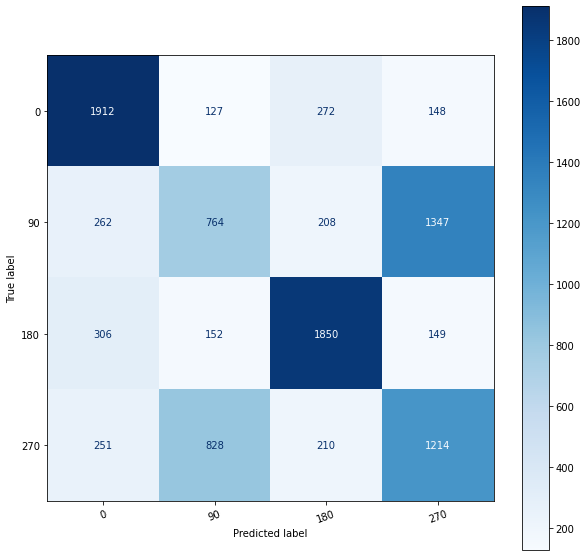

In [41]:
classes = rotations

plot_confusion_matrix(labels, pred_labels, classes)

In [0]:
corrects = torch.eq(labels, pred_labels)

In [0]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [0]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.5)

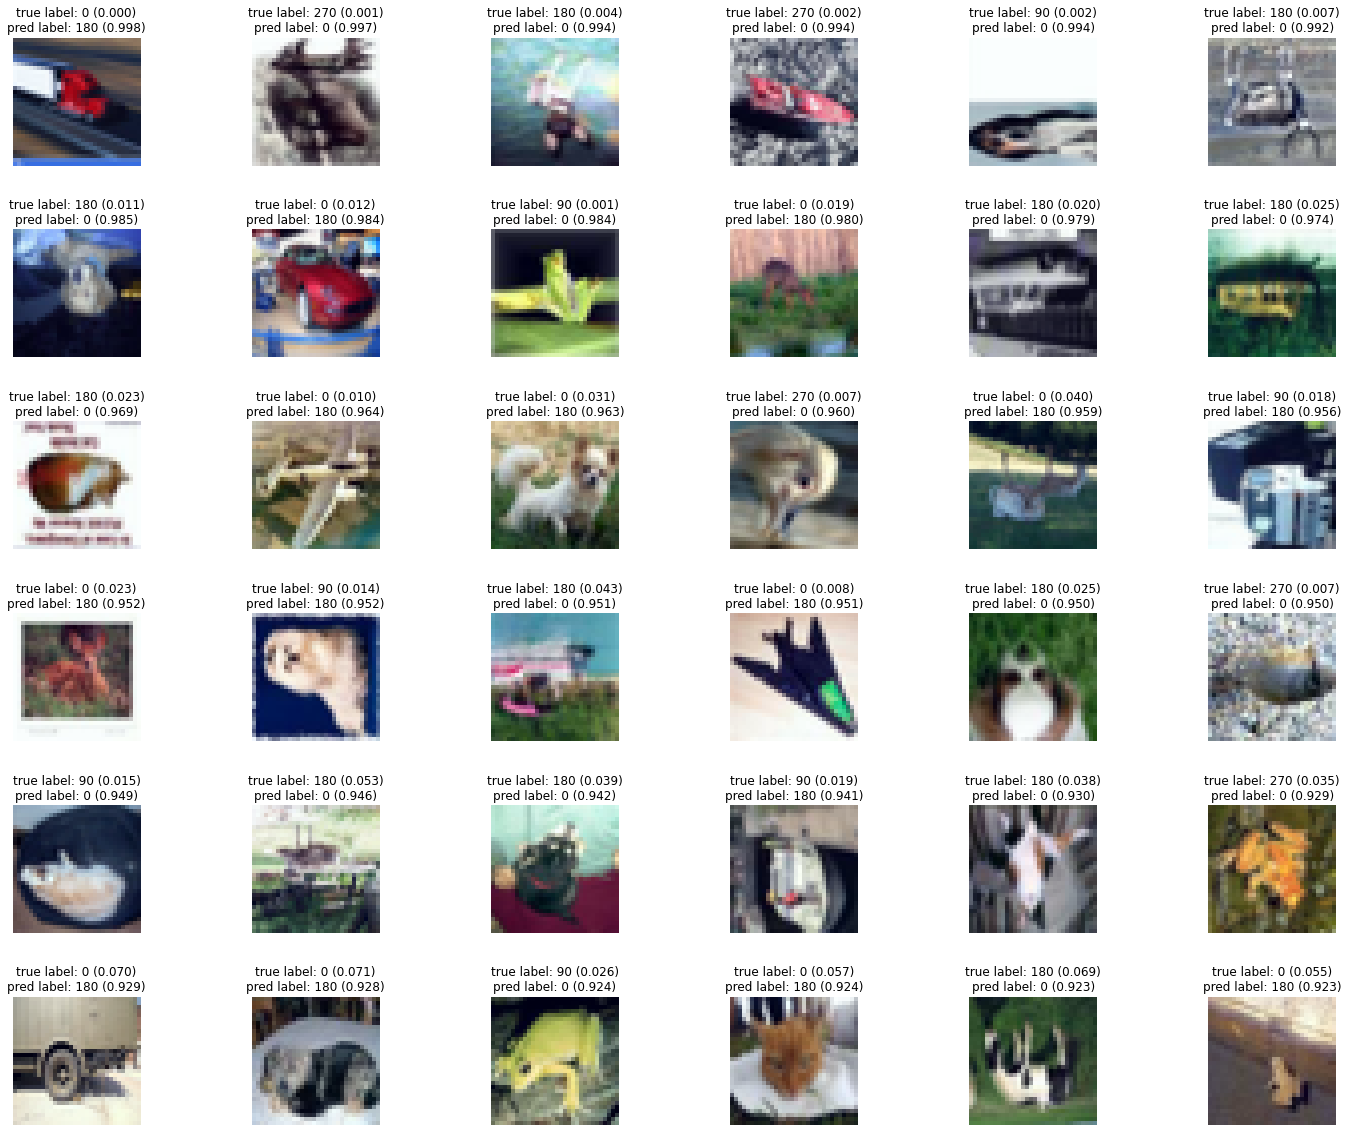

In [45]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [0]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms
test_data.transform = test_transforms

In [0]:
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [0]:
CLASSIFIER_OUTPUT_DIM = 10

final_fc = nn.Linear(512, CLASSIFIER_OUTPUT_DIM)

In [0]:
model.fc = final_fc.to(device)

In [0]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

In [51]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


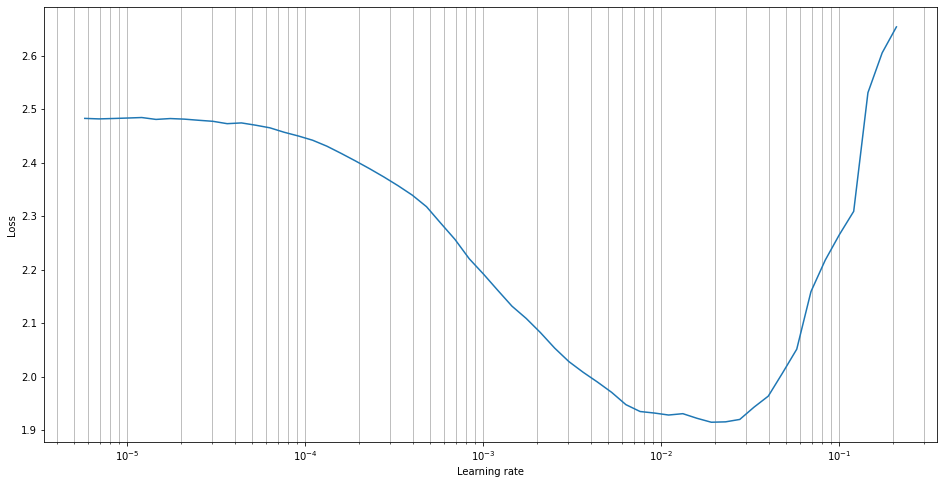

In [52]:
plot_lr_finder(lrs, losses, skip_start = 20, skip_end = 20)

In [0]:
FOUND_LR = 3e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [0]:
EPOCHS = 25
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                    max_lr = FOUND_LR,
                                    total_steps = TOTAL_STEPS)

In [55]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.374 | Train Acc: 50.76%
	 Val. Loss: 1.150 |  Val. Acc: 59.23%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 1.082 | Train Acc: 61.47%
	 Val. Loss: 1.024 |  Val. Acc: 62.76%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 1.014 | Train Acc: 63.83%
	 Val. Loss: 1.045 |  Val. Acc: 63.20%
Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.955 | Train Acc: 66.08%
	 Val. Loss: 0.961 |  Val. Acc: 66.38%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.905 | Train Acc: 68.09%
	 Val. Loss: 0.910 |  Val. Acc: 68.73%
Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 0.845 | Train Acc: 70.35%
	 Val. Loss: 0.833 |  Val. Acc: 71.46%
Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.783 | Train Acc: 72.45%
	 Val. Loss: 0.804 |  Val. Acc: 72.65%
Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.729 | Train Acc: 74.62%
	 Val. Loss: 0.747 |  Val. Acc: 74.09%
Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.680 | Train Acc: 76.17%
	 Val. Loss: 0.727 |  Val. Acc: 75.00%
Epoch: 10 | Epoch T

In [56]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.540 | Test Acc: 83.85%


In [0]:
images, labels, probs = get_predictions(model, test_iterator)

In [0]:
pred_labels = torch.argmax(probs, 1)

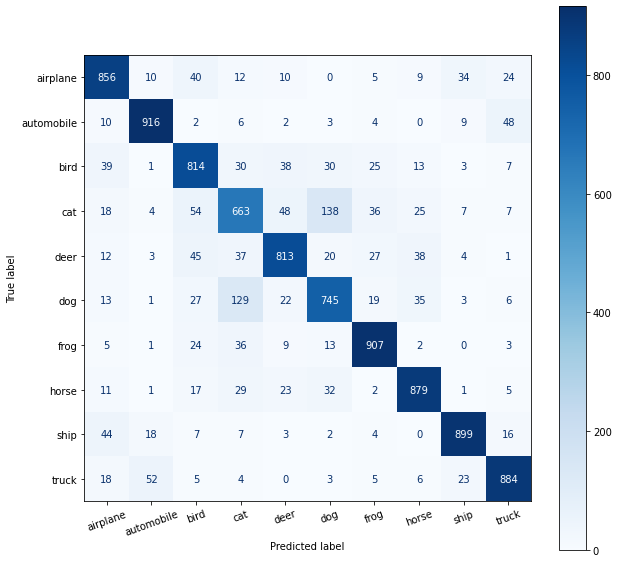

In [59]:
classes = test_data.classes

plot_confusion_matrix(labels, pred_labels, classes)

In [0]:
corrects = torch.eq(labels, pred_labels)

In [0]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

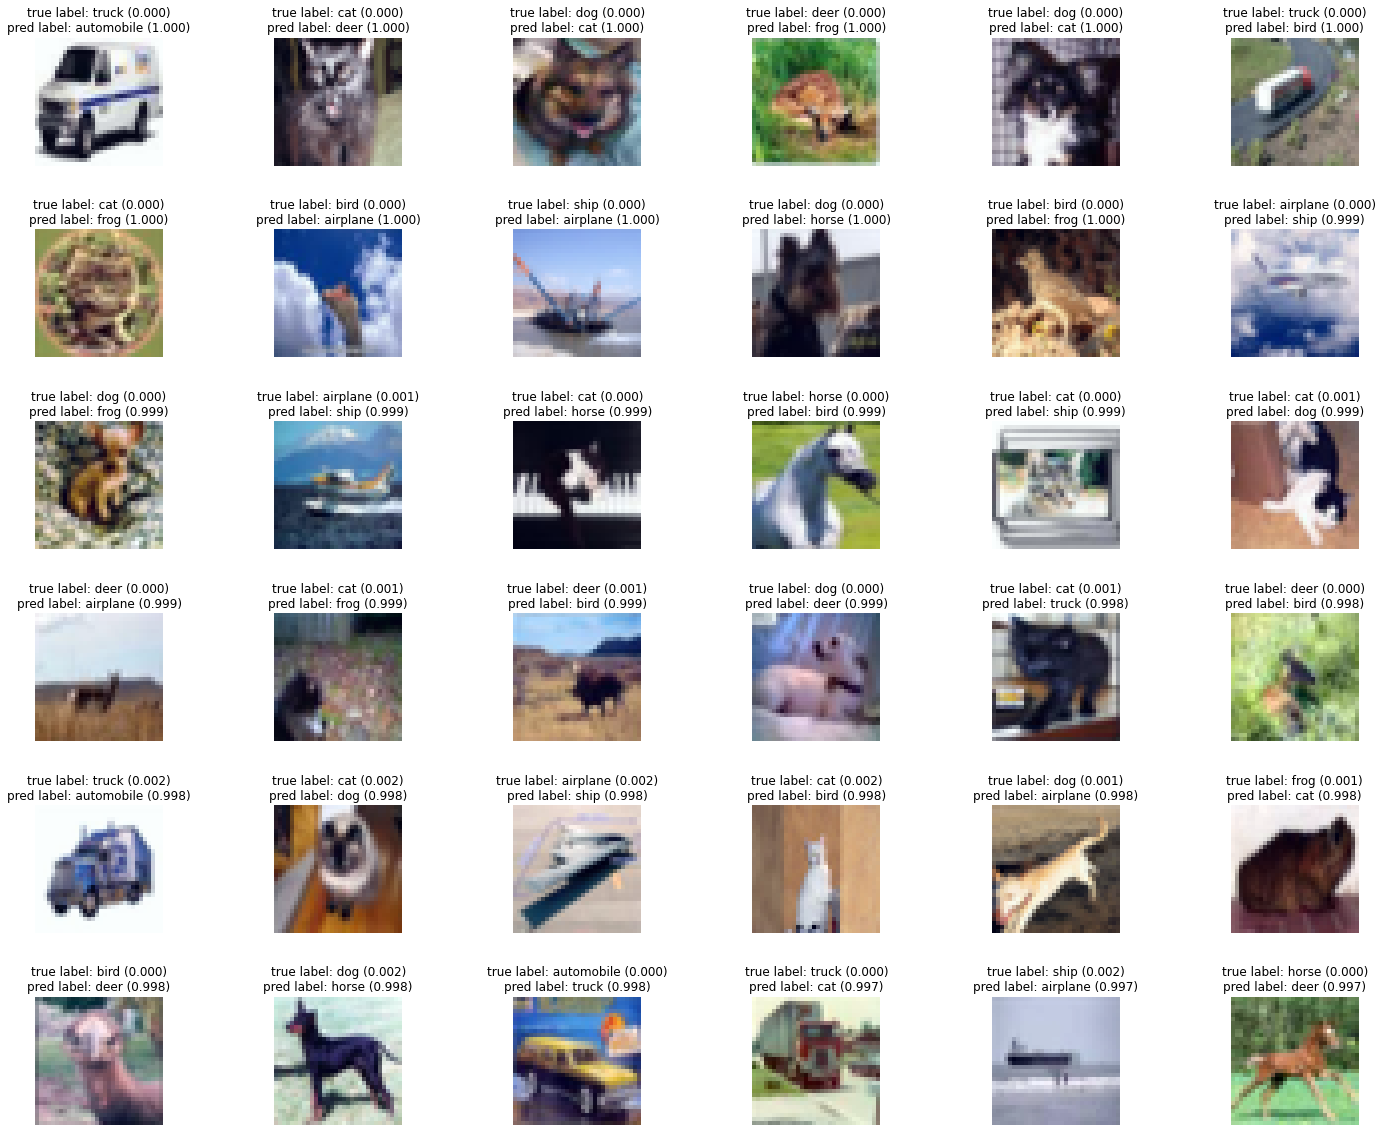

In [62]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [0]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [0]:
outputs, labels = get_representations(model, train_iterator)

In [0]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [0]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

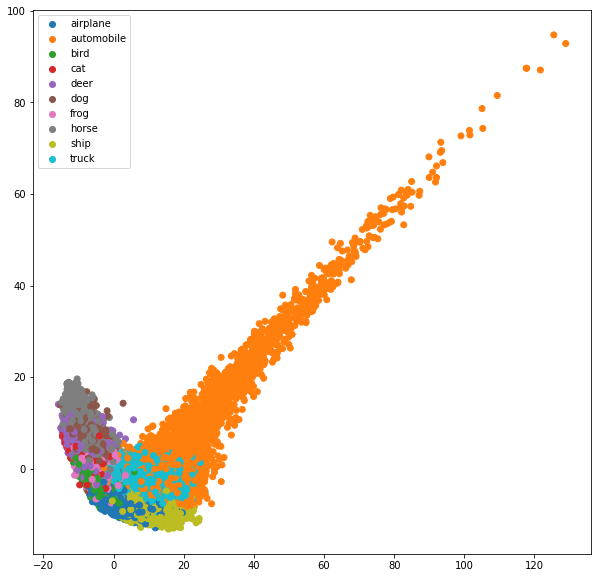

In [67]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [0]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

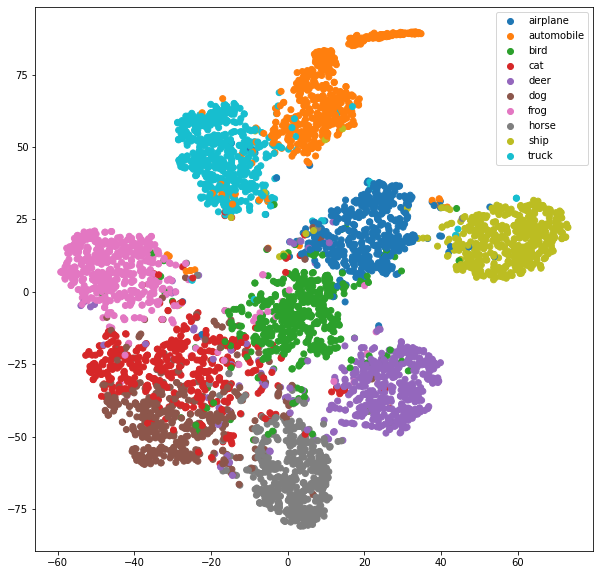

In [69]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

In [0]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = 0.3)

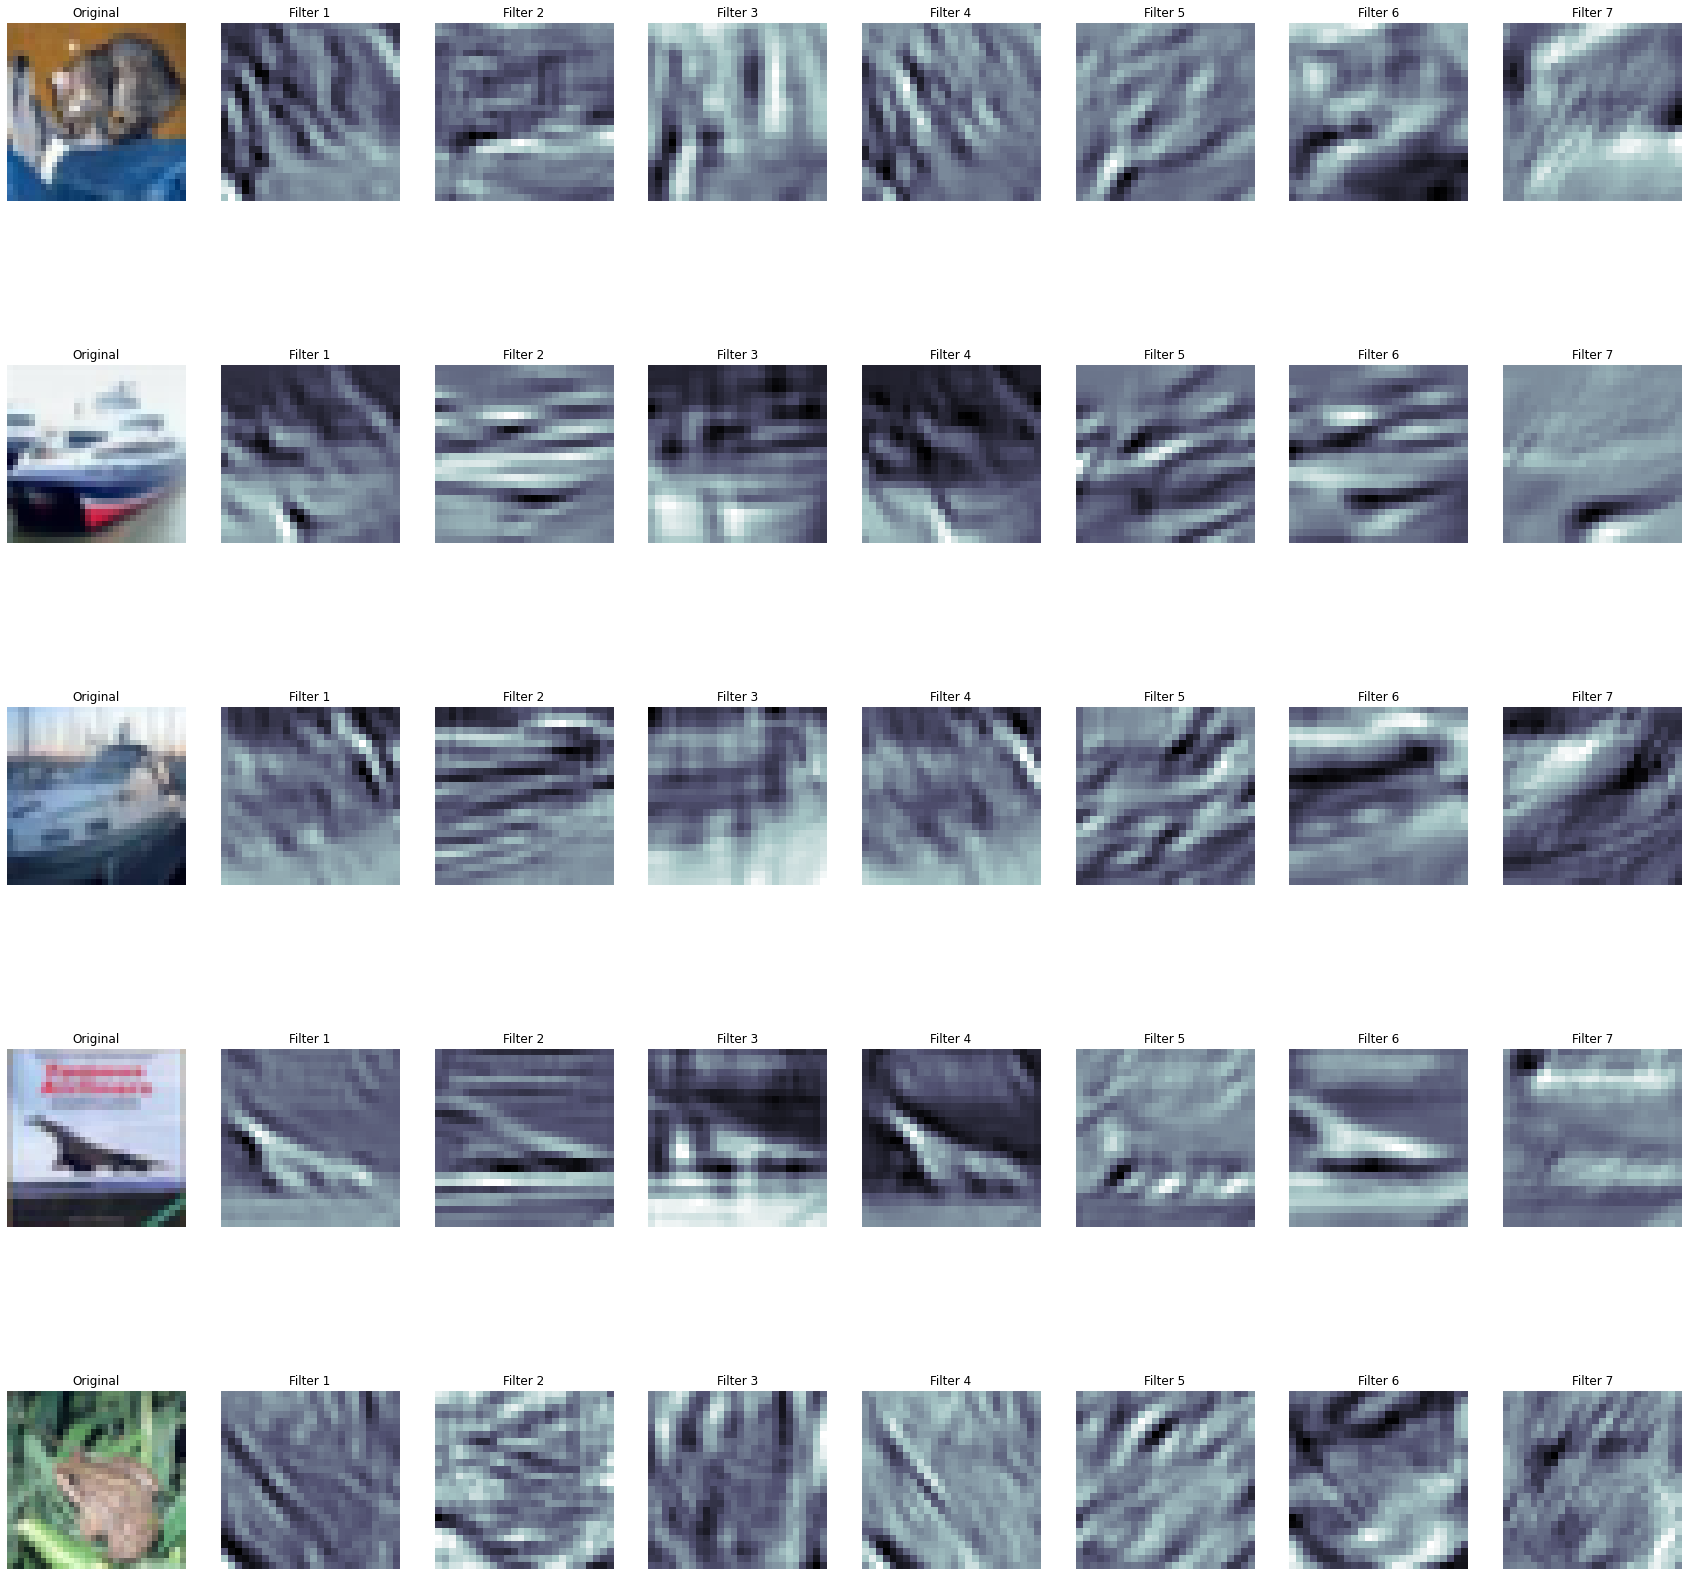

In [71]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [0]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

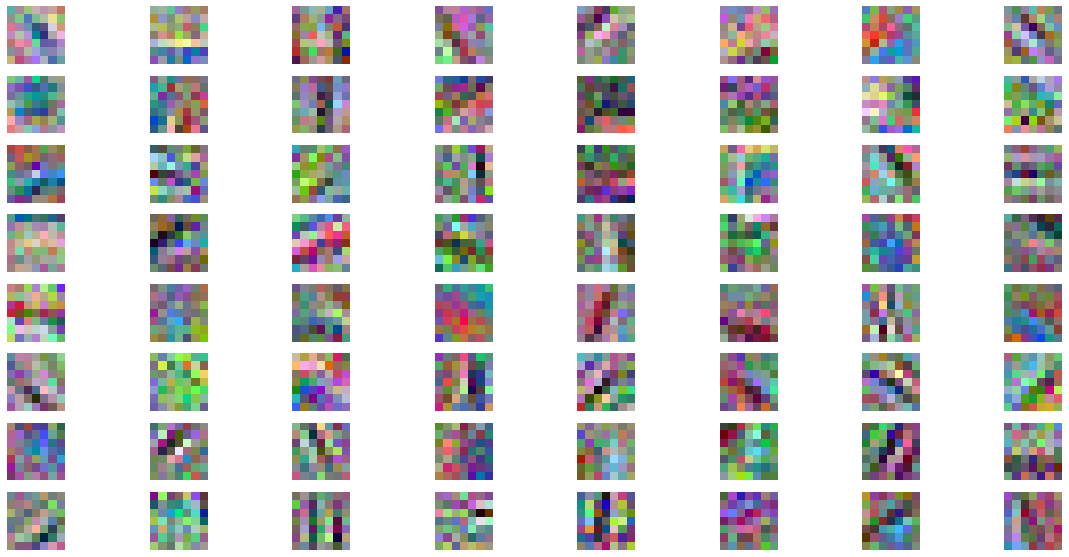

In [73]:
plot_filters(filters)

In [74]:
import torchvision.models as models

pretrained_resnet = models.resnet18(pretrained = True)

print(pretrained_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

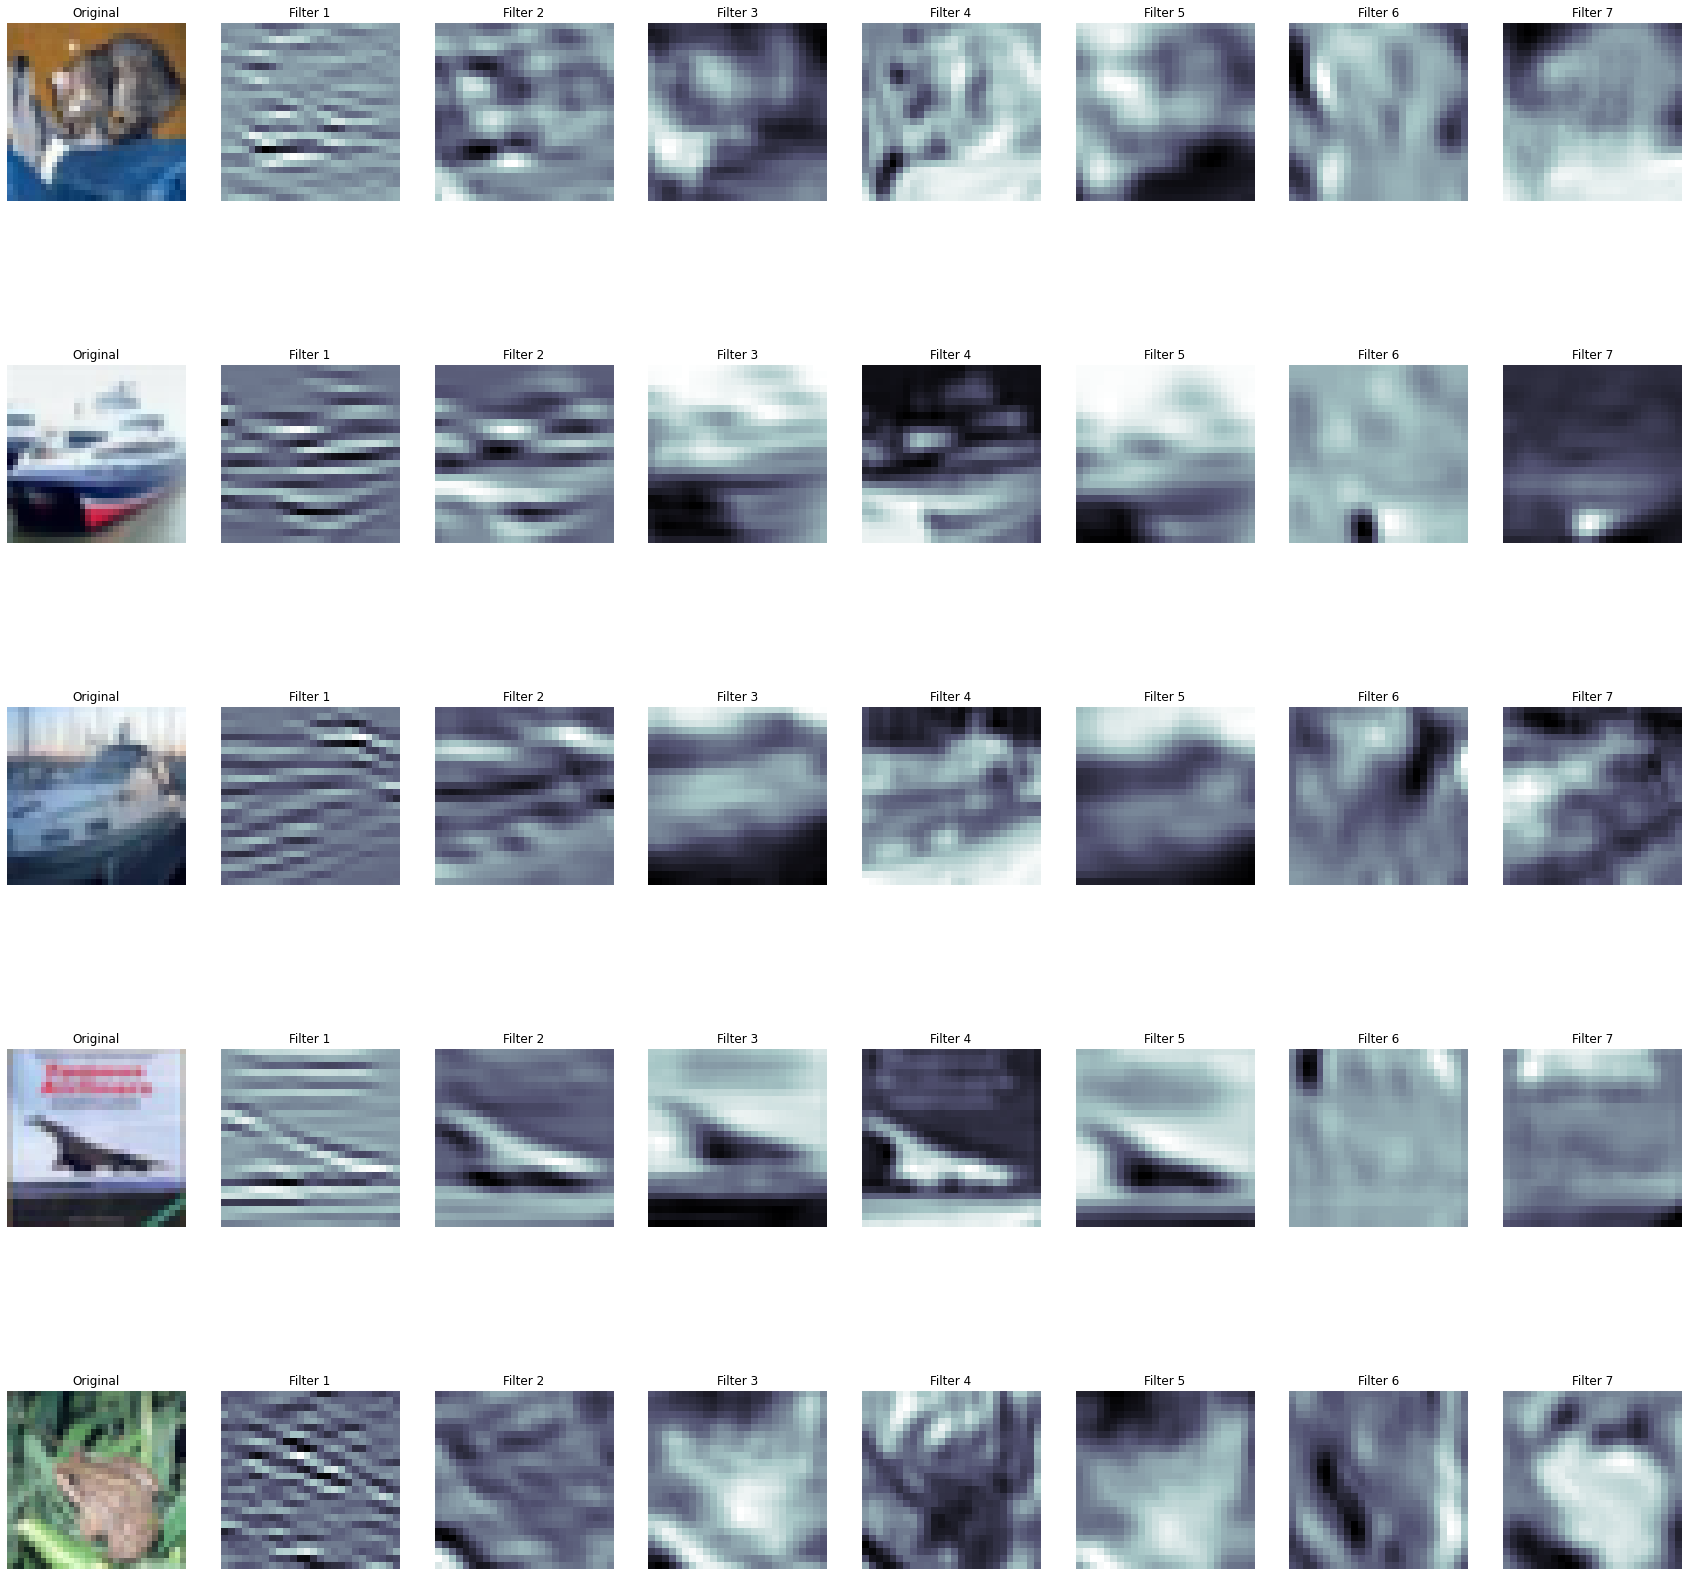

In [75]:
filters = pretrained_resnet.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

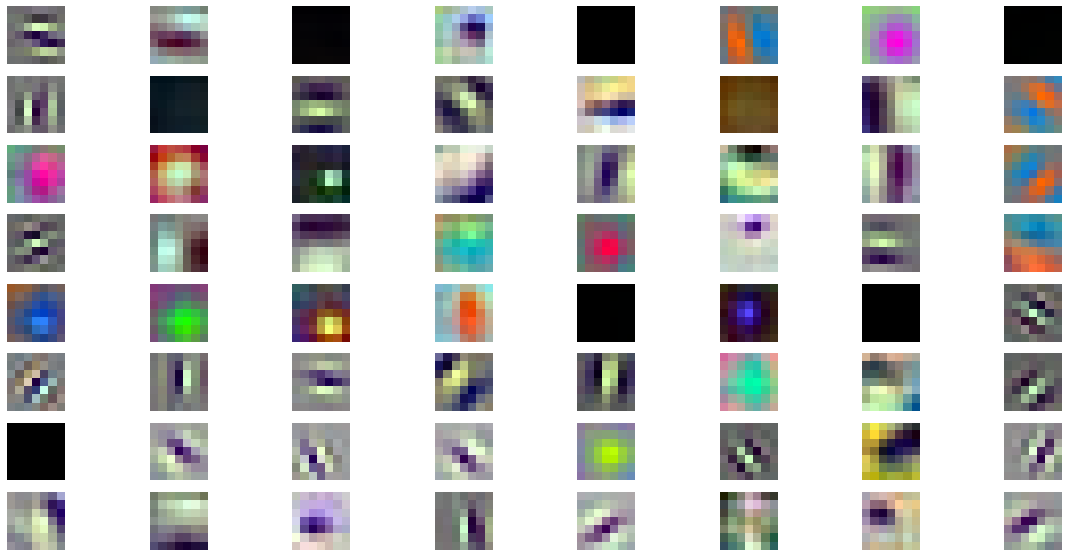

In [76]:
plot_filters(filters)